#**Рекомендательные системы** 

**Рекомендательная система** (recommender system) стремится максимально точно предсказать предпочтения потребителя и предложить наиболее подходящий товар или услугу.

**Коллаборативная рекомендательная система** - основывается на сопоставлении пользователей и товаров

Матрица предпочтений
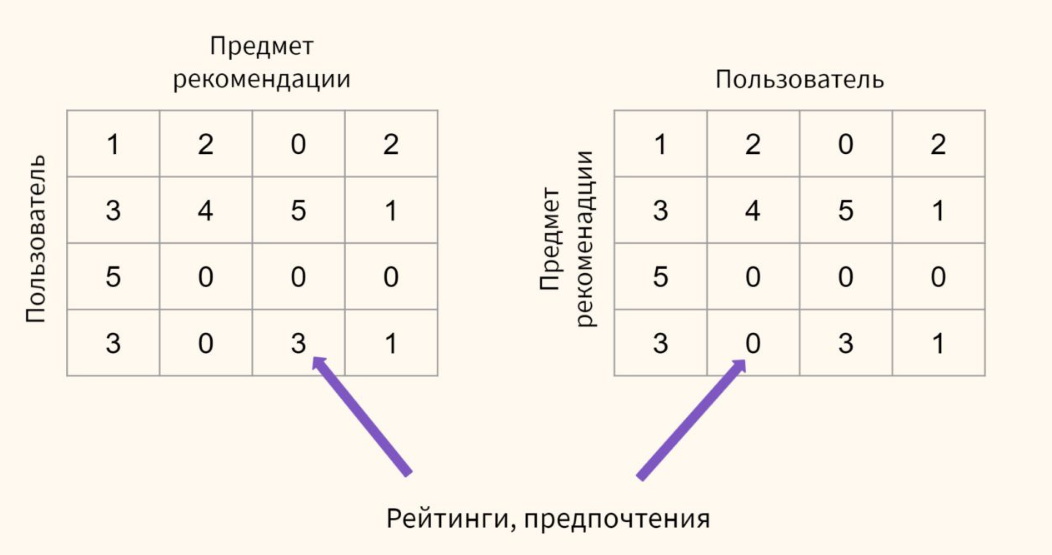






## **Пример разработки рекомендательной системы для кинотеатра**
 
Это коллаборативная система, основанная на **предмете рекомендации**.

**Матрица предпочтений:** строки - фильмы, столбцы — пользователи, а элементы — рейтинги.

Алгоритм k-ближайших соседей для определения расстояния от каждого фильма до ближайших векторов
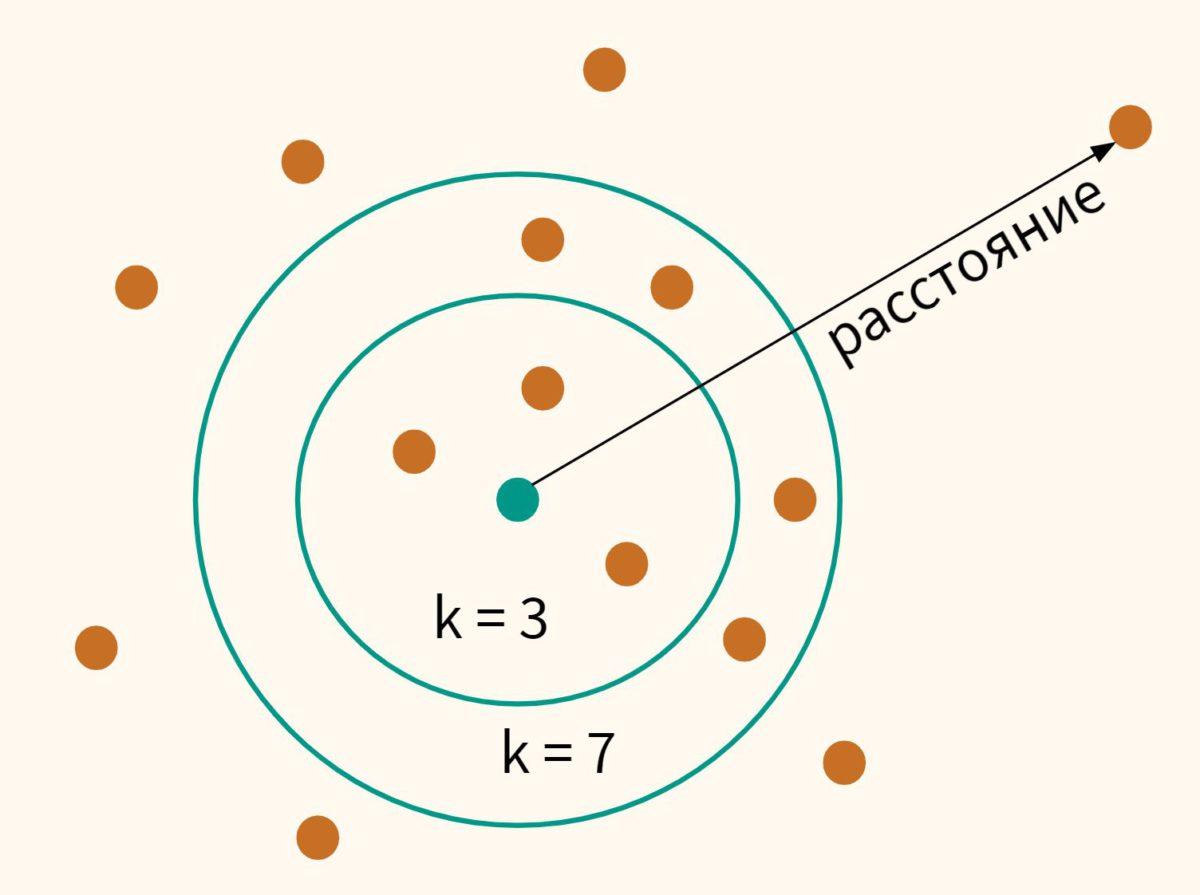

Поиск рекомендаций на основе косинусного сходства




### Использование датасетов о рейтинге фильмов MovieLens Latest Datasets.


In [3]:
import pandas as pd
import numpy as np

# модуль sparse библиотеки scipy понадобится для работы с разреженными матрицами 
from scipy.sparse import csr_matrix

from sklearn.neighbors import NearestNeighbors

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [4]:
movies.head(5) 

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
#удаление столбца
movies.drop(['genres'], axis = 1, inplace = True)
ratings.drop(['timestamp'], axis = 1, inplace = True)

### Создание матрицы предпочтений

In [7]:
# по горизонтали будут фильмы, по вертикали - пользователи, значения - оценки
user_item_matrix = ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating')
user_item_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#замена пропущенных значений 
user_item_matrix.fillna(0, inplace = True)
print(user_item_matrix.shape)
user_item_matrix.head()


(9724, 610)


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


**Чистка матрицы**

Необходимо убрать неактивных пользователей и фильмы с небольшим количеством оценок. С одной стороны, такие пользователи не окажут существенного влияния на расстояния между фильмами, с другой, малому количеству оценок довольно сложно доверять.

In [9]:
# вначале сгруппируем (объединим) пользователей, возьмем только столбец rating 
# и посчитаем, сколько было оценок у каждого пользователя
users_votes = ratings.groupby('userId')['rating'].agg('count')
 
# сделаем то же самое, только для фильма
movies_votes = ratings.groupby('movieId')['rating'].agg('count')
 
# теперь создадим фильтр (mask)
user_mask = users_votes[users_votes > 50].index
movie_mask = movies_votes[movies_votes > 10].index
 
# применим фильтры и отберем фильмы с достаточным количеством оценок
user_item_matrix = user_item_matrix.loc[movie_mask,:]
 
# а также активных пользователей
user_item_matrix = user_item_matrix.loc[:,user_mask]

print(user_item_matrix.shape)
user_item_matrix.head()

(2121, 378)


userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


### Преобразование разреженной матрицы
Преобразование данных матрицы в формат сжатого хранения строкой 

In [10]:
# атрибут values передаст функции csr_matrix только значения датафрейма
csr_data = csr_matrix(user_item_matrix.values)
print(csr_data)

  (0, 0)	4.0
  (0, 3)	4.5
  (0, 6)	2.5
  (0, 8)	4.5
  (0, 9)	3.5
  (0, 10)	4.0
  (0, 12)	3.5
  (0, 16)	3.0
  (0, 19)	3.0
  (0, 20)	3.0
  (0, 25)	5.0
  (0, 28)	5.0
  (0, 29)	4.0
  (0, 31)	3.0
  (0, 34)	5.0
  (0, 38)	5.0
  (0, 39)	4.0
  (0, 40)	4.0
  (0, 41)	2.5
  (0, 43)	4.5
  (0, 46)	0.5
  (0, 47)	4.0
  (0, 50)	2.5
  (0, 53)	4.0
  (0, 55)	3.0
  :	:
  (2118, 205)	4.0
  (2118, 345)	1.5
  (2118, 357)	4.0
  (2118, 369)	4.5
  (2119, 37)	3.5
  (2119, 62)	3.0
  (2119, 98)	0.5
  (2119, 127)	4.5
  (2119, 156)	4.5
  (2119, 236)	0.5
  (2119, 256)	4.5
  (2119, 317)	2.0
  (2119, 345)	2.0
  (2119, 357)	5.0
  (2119, 365)	3.5
  (2120, 37)	4.0
  (2120, 62)	5.0
  (2120, 146)	2.5
  (2120, 155)	4.5
  (2120, 156)	5.0
  (2120, 186)	5.0
  (2120, 205)	4.0
  (2120, 236)	3.0
  (2120, 317)	3.5
  (2120, 357)	4.0


In [11]:
user_item_matrix = user_item_matrix.rename_axis(None, axis = 1).reset_index()
user_item_matrix.head()

,movieId,1,4,6,7,10,11,15,16,17,...,600,601,602,603,604,605,606,607,608,610
0,1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
1,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
2,3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


### Создание модели машинного обучения 

На основе метода k-ближайших соседей

In [12]:
# создадим объект класса NearestNeighbors
# metric = ‘cosine’: косинусное сходство; algorithm = ‘brute’: полный перебор; 
# n_neighbors = 20: количество соседей; n_jobs = -1: вычисления на всех свободных ядрах процессора
knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors = 20, n_jobs = -1)
 
# обучим модель
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

### Получение рекомендаций

In [13]:
recommendations = 10
search_word = 'Matrix'

In [14]:
movie_search = movies[movies['title'].str.contains(search_word)]
movie_search

,movieId,title
1939,2571,"Matrix, The (1999)"
4351,6365,"Matrix Reloaded, The (2003)"
4639,6934,"Matrix Revolutions, The (2003)"


In [15]:
movie_id = movie_search.iloc[0]['movieId']
 
# далее по индексу фильма в датасете movies найдем соответствующий индекс
# в матрице предпочтений
movie_id = user_item_matrix[user_item_matrix['movieId'] == movie_id].index[0]
movie_id

901

In [16]:
print(csr_data[movie_id])

  (0, 0)	5.0
  (0, 1)	1.0
  (0, 4)	0.5
  (0, 6)	4.0
  (0, 7)	3.5
  (0, 8)	5.0
  (0, 9)	4.5
  (0, 10)	4.0
  (0, 12)	4.0
  (0, 15)	4.0
  (0, 17)	4.0
  (0, 20)	5.0
  (0, 21)	3.0
  (0, 24)	5.0
  (0, 26)	2.0
  (0, 27)	5.0
  (0, 29)	5.0
  (0, 31)	2.5
  (0, 33)	5.0
  (0, 34)	5.0
  (0, 36)	1.0
  (0, 37)	5.0
  (0, 38)	3.5
  (0, 39)	4.0
  (0, 40)	5.0
  :	:
  (0, 335)	5.0
  (0, 336)	5.0
  (0, 339)	4.5
  (0, 340)	4.0
  (0, 341)	5.0
  (0, 346)	4.5
  (0, 349)	5.0
  (0, 351)	5.0
  (0, 352)	5.0
  (0, 353)	5.0
  (0, 357)	5.0
  (0, 358)	4.0
  (0, 360)	4.0
  (0, 361)	5.0
  (0, 363)	2.5
  (0, 364)	5.0
  (0, 365)	4.0
  (0, 367)	5.0
  (0, 368)	3.0
  (0, 369)	5.0
  (0, 371)	5.0
  (0, 374)	5.0
  (0, 375)	5.0
  (0, 376)	5.0
  (0, 377)	5.0


In [17]:
#поиск индексов ближайших соседей 
#массив индексов фильмов (indices) и массив расстояний (distances) до них
distances, indices = knn.kneighbors(csr_data[movie_id], n_neighbors = recommendations + 1)


In [18]:
# уберем лишние измерения через squeeze() и преобразуем массивы в списки с помощью tolist()
indices_list = indices.squeeze().tolist()
distances_list = distances.squeeze().tolist()
 
indices_distances = list(zip(indices_list, distances_list))
 
# в набор кортежей (tuple)
print(type(indices_distances[0]))
 
# и посмотрим на первые три пары/кортежа
print(indices_distances[:3])

<class 'tuple'>
[(901, 0.0), (1002, 0.22982440568634488), (442, 0.25401128310081567)]


In [19]:
indices_distances_sorted = sorted(indices_distances, key = lambda x: x[1], reverse = False)

# и убрать первый элемент с индексом 901 (потому что это и есть "Матрица")
indices_distances_sorted = indices_distances_sorted[1:]
indices_distances_sorted

[(1002, 0.22982440568634488),
 (442, 0.25401128310081567),
 (454, 0.27565616686043737),
 (124, 0.2776088577731709),
 (735, 0.2869100842838125),
 (954, 0.2911101181714415),
 (1362, 0.31393358217709477),
 (1157, 0.31405925934381695),
 (1536, 0.3154800434449465),
 (978, 0.31748544046311844)]

In [20]:
# сопоставление индексам названия фильмов 
recom_list = []

# теперь в цикле будем поочередно проходить по кортежам
for ind_dist in indices_distances_sorted:

    # искать movieId в матрице предпочтений
    matrix_movie_id = user_item_matrix.iloc[ind_dist[0]]['movieId']

    # выяснять индекс этого фильма в датафрейме movies
    id = movies[movies['movieId'] == matrix_movie_id].index

    # брать название фильма и расстояние до него
    title = movies.iloc[id]['title'].values[0]
    dist = ind_dist[1]

    # помещать каждую пару в питоновский словарь
    # который, в свою очередь, станет элементом списка recom_list
    recom_list.append({'Title' : title, 'Distance' : dist})

In [21]:
recom_list[:5]

[{'Title': 'Fight Club (1999)', 'Distance': 0.22982440568634488},
 {'Title': 'Star Wars: Episode V - The Empire Strikes Back (1980)',
  'Distance': 0.25401128310081567},
 {'Title': 'Star Wars: Episode VI - Return of the Jedi (1983)',
  'Distance': 0.27565616686043737},
 {'Title': 'Star Wars: Episode IV - A New Hope (1977)',
  'Distance': 0.2776088577731709},
 {'Title': 'Saving Private Ryan (1998)', 'Distance': 0.2869100842838125}]

In [22]:
#преобразование в датафрейм
recom_df = pd.DataFrame(recom_list, index = range(1, recommendations + 1))
recom_df

,Title,Distance
1,Fight Club (1999),0.229824
2,Star Wars: Episode V - The Empire Strikes Back...,0.254011
3,Star Wars: Episode VI - Return of the Jedi (1983),0.275656
4,Star Wars: Episode IV - A New Hope (1977),0.277609
5,Saving Private Ryan (1998),0.286910
6,"Sixth Sense, The (1999)",0.291110
7,"Lord of the Rings: The Fellowship of the Ring,...",0.313934
8,Gladiator (2000),0.314059
9,"Lord of the Rings: The Return of the King, The...",0.315480
10,American Beauty (1999),0.317485


## Задание 
Найти подходящий датасет и по представленному принципу разработать рекомендательную систему 

Использованные источники
1. Машинное обучение. Сайт Дмитрия Макарова
https://www.dmitrymakarov.ru/intro/recommender-17/#0-chto-takoe-rekomendatelnaya-sistema